Uwaga! Mimo, ze w logach jednostkami są GB/s, to zweryfikowałem i są to GiB/s.

In [1]:
DATA_DIR="runs"

In [2]:
from pathlib import Path
import re

import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [3]:
params_path_pattern = r"GDS(\d)_MODE([a-z]+)/.*_bs(\d+)_.*_ninterthreads(\d+)_nintrathreads(\d+)"
results_pattern=r"""run (\d+):
total time: ([^\s]+) seconds for 200 samples
iteration time: ([^\s]+) seconds/sample
throughput: ([^\s]+) samples/second
bandwidth: ([^\s]+) GB/s
cpu utilization: ([^\s]+)%"""

In [4]:
measurements = []
for path in Path(DATA_DIR).glob("*/*"):
    params = re.search(params_path_pattern, str(path)).groups()
    with open(path) as f:
        scores = re.findall(results_pattern, f.read(), re.M)
    for score in scores:
        measurements.append(
            dict(itertools.chain(
                zip(["gds", "mode", "batch_size", "ninterthreads", "nintrathreads"], params),
                zip(["rep", "total_time (secs)", "iteration_time (secs/sample)", "throughput (samples/sec)", "bandwidth (GiB/sec)", "cpu_usage (%)"], score)
            ))
        )
measurements_df = pd.DataFrame(measurements)
measurements_df["gds"] = measurements_df["gds"] == "1"
measurements_df["mode"] = measurements_df["mode"].astype(
    CategoricalDtype(categories=measurements_df["mode"].unique(), ordered=True)
)
int_cols = ["batch_size", "ninterthreads", "nintrathreads", "rep"]
float_cols = ["total_time (secs)", "iteration_time (secs/sample)", "throughput (samples/sec)", "bandwidth (GiB/sec)", "cpu_usage (%)"]
measurements_df[int_cols] = measurements_df[int_cols].astype(int)
measurements_df[float_cols] = measurements_df[float_cols].astype(float)
measurements_df["threads"] = measurements_df["ninterthreads"] * measurements_df["nintrathreads"]

In [5]:
measurements_df

,gds,mode,batch_size,ninterthreads,nintrathreads,rep,total_time (secs),iteration_time (secs/sample),throughput (samples/sec),bandwidth (GiB/sec),cpu_usage (%),threads
0,True,inference,8,8,1,1,2.14,0.0107,93.52,4.93,9.25,8
1,True,inference,8,8,1,2,2.09,0.0105,95.57,5.04,9.48,8
2,True,inference,8,8,1,3,2.01,0.0100,99.67,5.26,9.23,8
3,True,inference,8,8,1,4,2.10,0.0105,95.27,5.02,8.84,8
4,True,inference,8,8,1,5,2.11,0.0106,94.74,5.00,8.51,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,False,inference,4,16,1,1,2.83,0.0142,70.60,3.72,7.38,16
1076,False,inference,4,16,1,2,2.69,0.0135,74.31,3.92,7.38,16
1077,False,inference,4,16,1,3,2.59,0.0129,77.33,4.08,7.15,16
1078,False,inference,4,16,1,4,2.72,0.0136,73.62,3.88,6.93,16


In [6]:
# GDS, batch_size, threads1, threads2 -> total_time

In [7]:
inference_df = measurements_df[measurements_df["mode"] == "inference"]

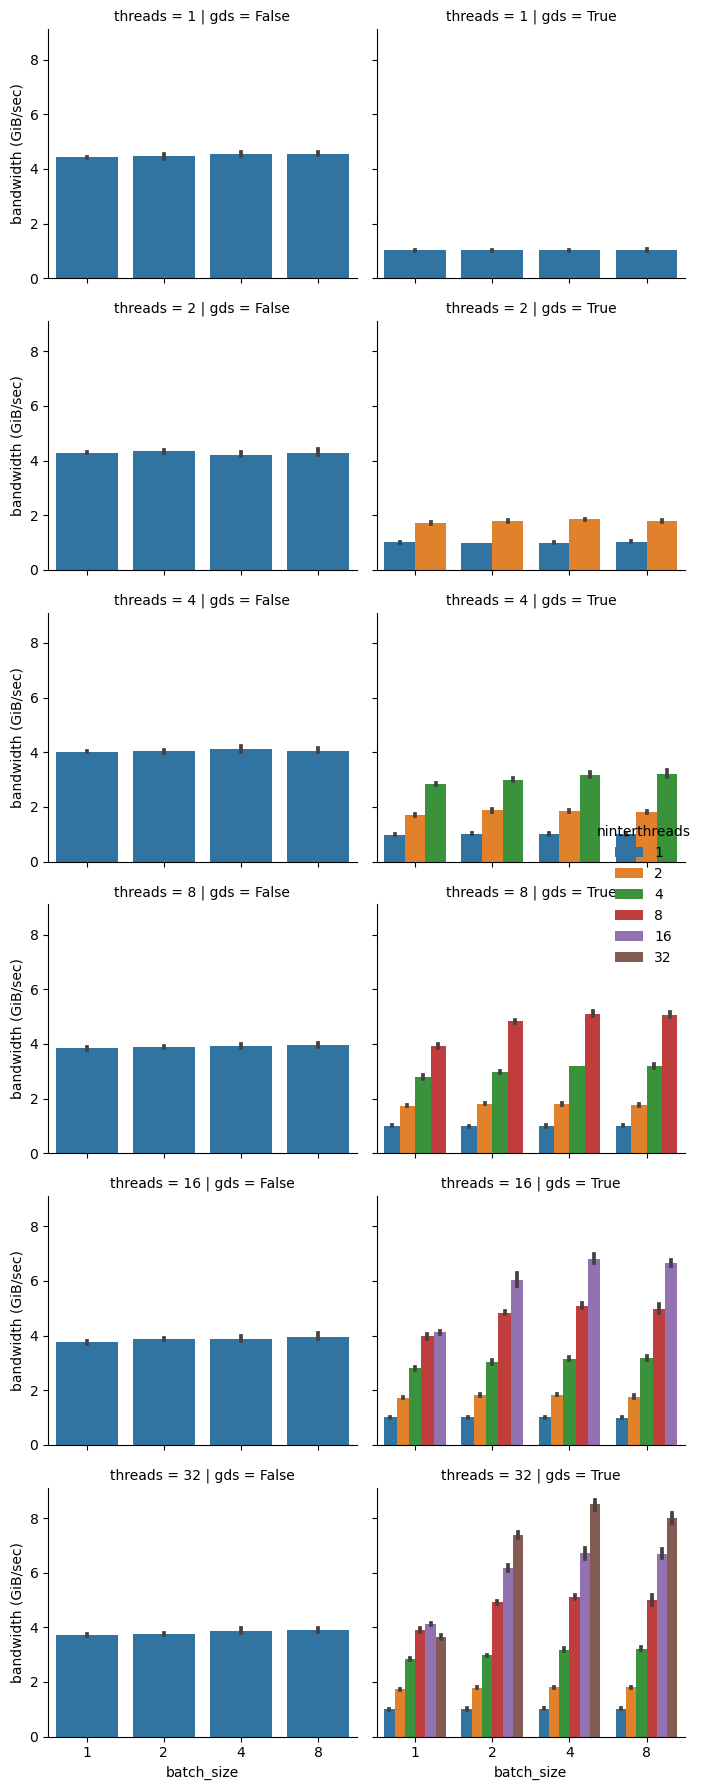

In [9]:
g = sns.FacetGrid(inference_df, row="threads", col="gds")
g.map_dataframe(
    sns.barplot, x="batch_size", y="bandwidth (GiB/sec)", hue="ninterthreads",
    palette=sns.color_palette(n_colors=inference_df.ninterthreads.nunique())
)
g.add_legend(title="ninterthreads")
plt.tight_layout()
plt.show()